# 数据处理

In [1]:
# 导入必要模块
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import gc
import datetime
import time
from sklearn.model_selection import train_test_split

In [2]:
# 可以发现不管是week，还是month ，all数据，字典都是这种结构，所以可以写成函数的形式
def data_process(data):
    Users, Volume, Transactions = [], [], []
    Position = data['xaxis']
    data = data['series']
    for i in data:
        if i['name'] == 'Users':
            Users.extend(i['data'])
        elif i['name'] == 'Volume':
            Volume.extend(i['data'])
        else:
            Transactions.extend(i['data'])
    
    return Users, Volume, Transactions, Position

# 对日期进行排序
def get_rank_data(users, volumn, transaction, position):
    dic = dict(zip(position, range(len(position))))
    p = []
    for i in sorted(dic):
        p.append(dic[i])
    users = np.asarray(users)[p].tolist()
    volumn = np.asarray(volumn)[p].tolist()
    transaction = np.asarray(transaction)[p].tolist()

    return users, volumn, transaction

In [3]:
# 数据读取和处理
week = pickle.load(open('./data/week.pkl', 'rb'))
month = pickle.load(open('./data/month.pkl', 'rb'))
all_ = pickle.load(open('./data/all_.pkl', 'rb'))

In [4]:
week_users, week_volume, week_transactions, week_position = data_process(week)
month_users, month_volume, month_transactions, month_position = data_process(month)
all_users, all_volume, all_transactions, all_position = data_process(all_)

In [5]:
week_users, week_volume, week_transactions = get_rank_data(week_users, week_volume, week_transactions, week_position)
month_users, month_volume, month_transactions = get_rank_data(month_users, month_volume, month_transactions, month_position)
all_users, all_volume, all_transactions = get_rank_data(all_users, all_volume, all_transactions, all_position)

In [6]:
# 没有用的变量可以删掉，避免占用内存
del week, month, all_, week_position, month_position, all_position; gc.collect()

100

In [7]:
# 因为没有时间，所以这里针对数据创建时间
date = pd.date_range('2019-9-17', '2021-3-30', freq='D') # 生成30号一共561个数据

In [8]:
# 创建pandas对象
df = pd.DataFrame({
    'transactions':all_transactions,
    'date':date
})

In [9]:
df = df.set_index(df.date)
del df['date']

<AxesSubplot:xlabel='date'>

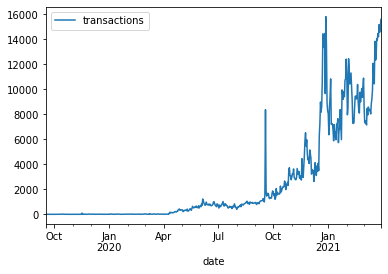

In [10]:
df.plot() # 粗略进行画图

In [11]:
data = df.sort_index(ascending=True, axis=0) # 按时间进行排序，虽然数据前面已经处理好了

<AxesSubplot:xlabel='date'>

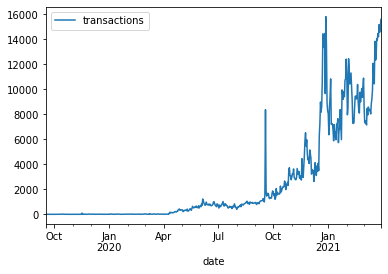

In [12]:
data.plot()

In [13]:
# 训练集和测试集的划分
train, test = train_test_split(data, test_size=0.2, shuffle=False) # 因为默认shuffle是打乱，这里设置为False

In [14]:
# 构造数据集
scaler = MinMaxScaler(feature_range=(0, 1)) # 进行归一化
scaler_train_data = scaler.fit_transform(train.values)
scaler_test_data = scaler.fit_transform(test.values)

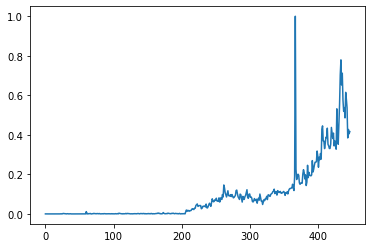

In [15]:
plt.plot(scaler_train_data)

# 构造训练集和测试集

In [16]:
scaler_train_data.shape

(448, 1)

In [17]:
window = 7 # 设置时间窗口，构造训练集和标签

In [18]:
# 构造数据集是为了输入到LSTM中
x_train, y_train = [], []
# 窗口为30表示，用30长度窗口滑动，前30个样本作为特征，后1个样本作为标签
for i in range(window, len(train)):
    x_train.append(scaler_train_data[i-window:i, 0])
    y_train.append(scaler_train_data[i, 0])

In [19]:
x_test, y_test = [], []
# 窗口为30表示，用30长度窗口滑动，前30个样本作为特征，后1个样本作为标签
for i in range(window, len(test)):
    x_test.append(scaler_test_data[i-window:i, 0])
    y_test.append(scaler_test_data[i, 0])

In [20]:
len(x_train), len(x_test) # 训练集数据量和测试集数据量

(441, 106)

In [21]:
x_train[0].shape, x_test[0].shape

((7,), (7,))

# 开始建模

## 数据类型转换

In [22]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [23]:
from torch.autograd import Variable

In [25]:
# 数据类型转换成numpy
x_train_tensor = torch.tensor(x_train).float()
y_train_tensor = torch.tensor(y_train).float()
x_test_tensor = torch.tensor(x_test).float()
y_test_tensor = torch.tensor(y_test).float()

In [27]:
x_train_tensor = x_train_tensor.reshape(-1, 1, window)
y_train_tensor = y_train_tensor.reshape(-1, 1, 1)
x_test_tensor = x_test_tensor.reshape(-1, 1, window)
y_test_tensor = y_test_tensor.reshape(-1, 1, 1)

In [29]:
x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape

(torch.Size([441, 1, 7]),
 torch.Size([441, 1, 1]),
 torch.Size([106, 1, 7]),
 torch.Size([106, 1, 1]))

## 开始训练模型

In [31]:
class LSTM(nn.Module):
    def __init__(self, input_dim=window, mid_dim=1024, num_classes=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, mid_dim, num_layers) # 表示输入维度为1，中间维度为1024， 由3个lstm链接而成
        self.linear = nn.Sequential(
                nn.Linear(mid_dim, mid_dim),
                nn.ReLU(),
                nn.Linear(mid_dim, num_classes))
        
    def forward(self, x):
        x, _ = self.lstm(x, None)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.linear(x)
        out = x.view(s, b, -1)
        return out

In [49]:
model = LSTM().cuda()

In [50]:
lr = 0.01
EPOCHS = 500
gamma = 0.5
step_size = 100

In [51]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [52]:
train_loss = []
test_loss = []

for epoch in range(EPOCHS):
    model.train()
    var_x = Variable(x_train.cuda())
    var_y = Variable(y_train.cuda())
    
    out = model(var_x)
    
    loss = criterion(out, var_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'EPOCH:{epoch},Train Loss:{loss.item():.5f}')
        
    train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
        var_tx = Variable(x_test.cuda())
        var_ty = Variable(y_test.cuda())
        
        out = model(var_tx)
        loss = criterion(out, var_ty)
        if epoch % 50 == 0:
            print(f'Test Loss:{loss.item():.5f}')
            
        test_loss.append(loss.item())
            
    scheduler.step() # 学习率递减

NameError: name 'Variable' is not defined

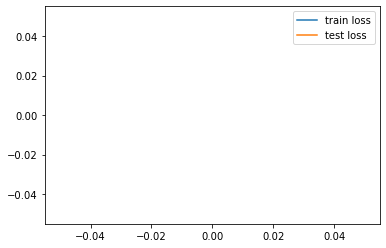

In [53]:
plt.figure()
plt.plot(train_loss, '-', label='train loss')
plt.plot(test_loss, '-', label='test loss')
plt.legend()
plt.show()

**TODO**:
- [ ] 可以尝试对学习率的loss进行可视化

# 建模结果分析

In [33]:
model.eval()
with torch.no_grad():
    var_tx = Variable(x_test.cuda())
    var_ty = Variable(y_test.cuda())

    out = model(var_tx)

In [34]:
# 由于我是用前10天的数据预测后一段时间的数据
len(scaler_train_data), len(x_train)

(304, 297)

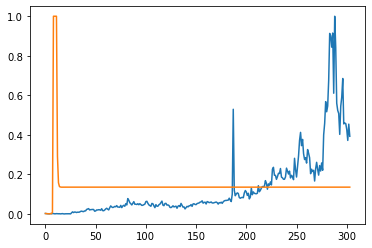

In [35]:
y_train_preds = model(x_train.cuda()).cpu().detach().numpy().flatten()
tmp = np.concatenate([scaler_train_data[:window].flatten(), y_train_preds])
tmp[np.abs(tmp) > 1] = 1 # 对预测的异常值进行裁剪

plt.figure()
plt.plot(scaler_train_data)
plt.plot(tmp)
plt.show()

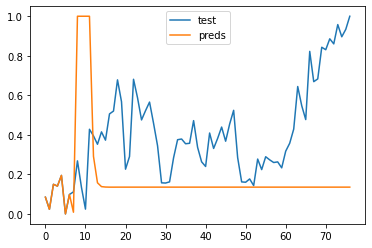

In [36]:
# 测试集的预测走向图
y_test_preds = model(x_test.cuda()).cpu().detach().numpy().flatten()
tmp = np.concatenate([scaler_test_data[:window].flatten(), y_test_preds])
tmp[np.abs(tmp) > 1] = 1 # 对预测的异常值进行裁剪
plt.figure()
plt.plot(scaler_test_data, label='test')
plt.plot(tmp, label='preds')
plt.legend()
plt.show()

**为什么到了后面就预测为直线了，因为我是将所有的序列全部输入进去了，神经网络预测的就是整体的趋势，所以变成了一条直线**

参考：https://zhuanlan.zhihu.com/p/43783719

# 模型优化

## 开始建模

In [102]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [103]:
class MyDataset(Dataset):
    def __init__(self, features, labels, transformer=True):
        super().__init__()
        if transformer:
            self.features = torch.tensor(features).float().unsqueeze(dim=-1)
            self.labels = torch.tensor(labels).float()
        else:
            self.features = features.float().squeeze().unsqueeze(dim=-1)
            self.labels = labels.float()
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.labels)    

In [104]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1, mid_dim=256, num_classes=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, mid_dim, num_layers, batch_first=True) # 表示输入维度为1，中间维度为1024， 由3个lstm链接而成
        self.linear = nn.Sequential(
                nn.Linear(mid_dim, mid_dim),
                nn.ReLU(),
                nn.Linear(mid_dim, num_classes))
        
    def forward(self, x):
        x, _ = self.lstm(x, None)
        s, b, h = x.shape
        x = x[:, -1, :]
        out = self.linear(x)
        return out

In [105]:
lr = 0.01
EPOCHS = 500
gamma = 0.5
step_size = 100

In [106]:
train_set = MyDataset(x_train_tensor, y_train_tensor, transformer=False)

In [107]:
train_set[0][0].shape

torch.Size([7, 1])

In [108]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [109]:
test_set = MyDataset(x_test_tensor, y_test_tensor, transformer=False)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [110]:
model = LSTM().cuda()

In [111]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [112]:
train_loss = []
test_loss = []

for epoch in range(EPOCHS):
    model.train()
    for x, y in train_loader:
        var_x = x.cuda()
        var_y = y.cuda()

        out = model(var_x)

        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f'EPOCH:{epoch},Train Loss:{loss.item():.5f}')

    train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            var_tx = x.cuda()
            var_ty = y.cuda()

            out = model(var_tx)
            loss = criterion(out, var_ty)
        test_loss.append(loss.item())
            
    if epoch % 50 == 0:
        print(f'Test Loss:{loss.item():.5f}')
    
    scheduler.step() # 学习率递减

EPOCH:0,Train Loss:8.60428
Test Loss:9.35197
EPOCH:50,Train Loss:0.00818
Test Loss:0.11800
EPOCH:100,Train Loss:0.00840
Test Loss:0.18051
EPOCH:150,Train Loss:0.00026
Test Loss:0.21232
EPOCH:200,Train Loss:0.00429
Test Loss:0.20440
EPOCH:250,Train Loss:0.00987
Test Loss:0.15880
EPOCH:300,Train Loss:0.00646
Test Loss:0.28916
EPOCH:350,Train Loss:0.00000
Test Loss:0.15129
EPOCH:400,Train Loss:0.01332
Test Loss:0.26070
EPOCH:450,Train Loss:0.00542
Test Loss:0.24324


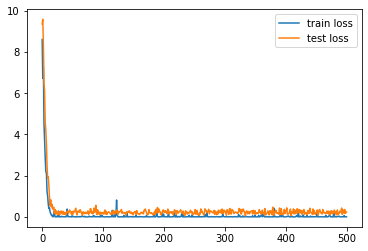

In [114]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

In [96]:
len(train_loss), len(test_loss)

(500, 500)

## 建模结果可视化

In [117]:
from tqdm import tqdm

In [119]:
train_preds = []
for x in tqdm(x_train_tensor):
    x = x.unsqueeze(dim=-1).cuda()
    preds = model(x)
    train_preds.append(preds.item())

100%|██████████| 441/441 [00:00<00:00, 1395.23it/s]


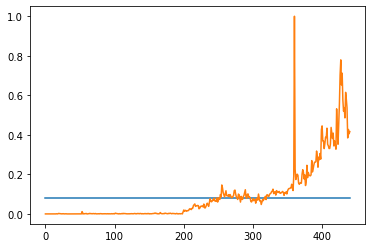

In [124]:
plt.figure()
plt.plot(train_preds)
plt.plot(y_train_tensor.flatten().tolist())
plt.show()

# 参考模型

In [126]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # 输入尺寸为 1，表示一天的数据
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -1, :])          # 取最后一天作为输出
        
        return out

In [127]:
class TrainSet(Dataset):
    def __init__(self, data, label):
        # 定义好 image 的路径
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = data.float(), label.float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [128]:
window = 7 # 设置时间窗口，构造训练集和标签

In [129]:
# 构造数据集是为了输入到LSTM中
x_train, y_train = [], []
# 窗口为30表示，用30长度窗口滑动，前30个样本作为特征，后1个样本作为标签
for i in range(window, len(train)):
    x_train.append(train.values[i-window:i].flatten())
    y_train.append(train.values[i].flatten())

In [130]:
x_test, y_test = [], []
# 窗口为30表示，用30长度窗口滑动，前30个样本作为特征，后1个样本作为标签
for i in range(window, len(test)):
    x_test.append(test.values[i-window:i, 0].flatten())
    y_test.append(test.values[i, 0].flatten())

In [131]:
train_data_numpy = np.array(x_train)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

In [132]:
train_data_tensor.shape

torch.Size([441, 7])

In [133]:
label_numpy = np.array(y_train)
label_mean = np.mean(label_numpy)
label_std  = np.std(label_numpy)
label_data_numpy = (label_numpy - label_mean) / label_std
labels = torch.Tensor(label_data_numpy)

In [134]:
labels.shape

torch.Size([441, 1])

In [135]:
# 创建 dataloader
train_set = MyDataset(train_data_tensor, labels)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

<ipython-input-103-237ea324ac7b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features).float().unsqueeze(dim=-1)
<ipython-input-103-237ea324ac7b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels).float()


In [136]:
model = LSTM().cuda()

In [137]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [138]:
train_loss = []
test_loss = []

for epoch in range(EPOCHS):
    model.train()
    for x, y in train_loader:
        var_x = x.cuda()
        var_y = y.cuda()

        out = model(var_x)

        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f'EPOCH:{epoch},Train Loss:{loss.item():.5f}')

    train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            var_tx = x.cuda()
            var_ty = y.cuda()

            out = model(var_tx)
            loss = criterion(out, var_ty)
        test_loss.append(loss.item())
            
    if epoch % 50 == 0:
        print(f'Test Loss:{loss.item():.5f}')
    
    scheduler.step() # 学习率递减

EPOCH:0,Train Loss:0.09234
Test Loss:2.46865


/home/zwl/miniconda3/envs/python38_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zwl/miniconda3/envs/python38_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCH:50,Train Loss:0.65940
Test Loss:2.77337
EPOCH:100,Train Loss:0.37121
Test Loss:2.39430
EPOCH:150,Train Loss:0.18913
Test Loss:2.94967
EPOCH:200,Train Loss:0.17024
Test Loss:0.85899
EPOCH:250,Train Loss:0.22119
Test Loss:1.29494
EPOCH:300,Train Loss:0.00042
Test Loss:0.36902
EPOCH:350,Train Loss:0.08135
Test Loss:0.88103
EPOCH:400,Train Loss:0.02721
Test Loss:0.97798
EPOCH:450,Train Loss:0.28567
Test Loss:0.52971


In [140]:
from tqdm import tqdm

In [141]:
generate_train_data = []
generate_test_data = []
for x in tqdm(train_data_tensor):
    x = x.unsqueeze(dim=-1).unsqueeze(dim=0).cuda()
    train_preds = model(x)
    generate_train_data.append(train_preds.item())

100%|██████████| 441/441 [00:00<00:00, 2064.71it/s]


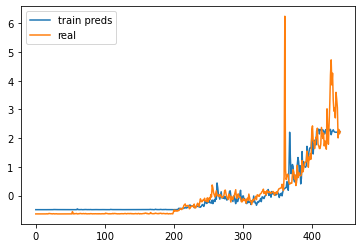

In [145]:
plt.figure()
plt.plot(generate_train_data, label='train preds')
plt.plot(labels, label='real')
plt.legend()
plt.show()

# 完整代码

## 数据处理 

In [1]:
# 导入必要模块
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import gc
import datetime
import time
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
# 可以发现不管是week，还是month ，all数据，字典都是这种结构，所以可以写成函数的形式
def data_process(data):
    Users, Volume, Transactions = [], [], []
    Position = data['xaxis']
    data = data['series']
    for i in data:
        if i['name'] == 'Users':
            Users.extend(i['data'])
        elif i['name'] == 'Volume':
            Volume.extend(i['data'])
        else:
            Transactions.extend(i['data'])
    
    return Users, Volume, Transactions, Position

# 对日期进行排序
def get_rank_data(users, volumn, transaction, position):
    dic = dict(zip(position, range(len(position))))
    p = []
    for i in sorted(dic):
        p.append(dic[i])
    users = np.asarray(users)[p].tolist()
    volumn = np.asarray(volumn)[p].tolist()
    transaction = np.asarray(transaction)[p].tolist()

    return users, volumn, transaction

In [4]:
# 数据读取和处理
week = pickle.load(open('./data/week.pkl', 'rb'))
month = pickle.load(open('./data/month.pkl', 'rb'))
all_ = pickle.load(open('./data/all_.pkl', 'rb'))

week_users, week_volume, week_transactions, week_position = data_process(week)
month_users, month_volume, month_transactions, month_position = data_process(month)
all_users, all_volume, all_transactions, all_position = data_process(all_)

week_users, week_volume, week_transactions = get_rank_data(week_users, week_volume, week_transactions, week_position)
month_users, month_volume, month_transactions = get_rank_data(month_users, month_volume, month_transactions, month_position)
all_users, all_volume, all_transactions = get_rank_data(all_users, all_volume, all_transactions, all_position)

# 没有用的变量可以删掉，避免占用内存
del week, month, all_, week_position, month_position, all_position; gc.collect()

# 因为没有时间，所以这里针对数据创建时间
date = pd.date_range('2019-9-17', '2021-3-30', freq='D') # 生成30号一共561个数据

# 创建pandas对象
df = pd.DataFrame({
    'transactions':all_transactions,
    'date':date
})

df = df.set_index(df.date)
del df['date']

data = df.sort_index(ascending=True, axis=0) # 按时间进行排序，虽然数据前面已经处理好了

# 训练集和测试集的划分
train, test = train_test_split(data, test_size=0.2, shuffle=False) # 因为默认shuffle是打乱，这里设置为False

## 数据转换

In [5]:
# 数据归一化，不然loss降不下来
window = 7 # 设置时间窗口，构造训练集和标签

# 构造数据集是为了输入到LSTM中
x_train, y_train = [], []
# 窗口为30表示，用30长度窗口滑动，前30个样本作为特征，后1个样本作为标签
for i in range(window, len(train)):
    x_train.append(train.values[i-window:i].flatten())
    y_train.append(train.values[i].flatten())
    
x_test, y_test = [], []
# 窗口为30表示，用30长度窗口滑动，前30个样本作为特征，后1个样本作为标签
for i in range(window, len(test)):
    x_test.append(test.values[i-window:i, 0].flatten())
    y_test.append(test.values[i, 0].flatten())

In [6]:
train_numpy = np.array(x_train)
train_mean = np.mean(train_numpy)
train_std  = np.std(train_numpy)
train_numpy = (train_numpy - train_mean) / train_std
train_tensor = torch.Tensor(train_numpy)

In [7]:
label_numpy = np.array(y_train)
label_mean = np.mean(label_numpy)
label_std  = np.std(label_numpy)
label_numpy = (label_numpy - label_mean) / label_std
train_labels = torch.Tensor(label_numpy)

In [8]:
test_numpy = np.array(x_test)
test_mean = np.mean(test_numpy)
test_std  = np.std(test_numpy)
test_numpy = (test_numpy - test_mean) / test_std
test_tensor = torch.Tensor(test_numpy)

In [9]:
label_numpy = np.array(y_test)
label_mean = np.mean(label_numpy)
label_std  = np.std(label_numpy)
label_numpy = (label_numpy - label_mean) / label_std
test_labels = torch.Tensor(label_numpy)

## 建立模型

In [10]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim=1, mid_dim=256, num_classes=1, num_layers=2):
#         super().__init__()
#         self.lstm = nn.LSTM(input_dim, mid_dim, num_layers, batch_first=True) # 表示输入维度为1，中间维度为1024， 由3个lstm链接而成
#         self.linear = nn.Sequential(
#                 nn.Linear(mid_dim, mid_dim),
#                 nn.ReLU(),
#                 nn.Linear(mid_dim, num_classes))
        
#     def forward(self, x):
#         x, _ = self.lstm(x, None)
#         s, b, h = x.shape
#         x = x[:, -1, :]
#         out = self.linear(x)
#         return out
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,   # 输入尺寸为 1，表示一天的数据
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)   # None 表示 hidden state 会用全 0 的 state
        out = self.out(r_out[:, -1, :])          # 取最后一天作为输出
        
        return out

In [11]:
class MyDataset(Dataset):
    def __init__(self, features, labels, transformer=True):
        super().__init__()
        if transformer:
            self.features = torch.tensor(features).float().unsqueeze(dim=-1)
            self.labels = torch.tensor(labels).float()
        else:
            self.features = features.float().squeeze().unsqueeze(dim=-1)
            self.labels = labels.float()
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.labels)    

In [12]:
lr = 0.01
EPOCHS = 500
gamma = 0.5
step_size = 100

In [13]:
train_set = MyDataset(train_tensor, train_labels, transformer=False)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_set = MyDataset(test_tensor, test_labels, transformer=False)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [14]:
model = LSTM().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [15]:
train_loss = []
test_loss = []

for epoch in range(EPOCHS):
    model.train()
    for x, y in train_loader:
        var_x = x.cuda()
        var_y = y.cuda()

        out = model(var_x)

        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f'EPOCH:{epoch},Train Loss:{loss.item():.5f}')

    train_loss.append(loss.item())
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            var_tx = x.cuda()
            var_ty = y.cuda()

            out = model(var_tx)
            loss = criterion(out, var_ty)
        test_loss.append(loss.item())
            
    if epoch % 50 == 0:
        print(f'Test Loss:{loss.item():.5f}')
    
    scheduler.step() # 学习率递减

EPOCH:0,Train Loss:0.05795
Test Loss:1.87113
EPOCH:50,Train Loss:0.27477
Test Loss:0.54276
EPOCH:100,Train Loss:0.00255
Test Loss:1.45956
EPOCH:150,Train Loss:0.07736
Test Loss:1.78276
EPOCH:200,Train Loss:0.00870
Test Loss:2.95642
EPOCH:250,Train Loss:0.19664
Test Loss:1.28106
EPOCH:300,Train Loss:0.91590
Test Loss:2.08889
EPOCH:350,Train Loss:0.00033
Test Loss:2.48318
EPOCH:400,Train Loss:0.02036
Test Loss:2.58839
EPOCH:450,Train Loss:0.01134
Test Loss:2.11029


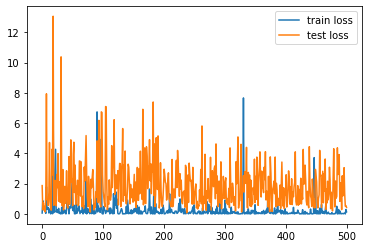

In [16]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

In [17]:
train_tensor[0].shape

torch.Size([7])

In [18]:
train_preds = []
for x in tqdm(train_tensor):
    x = x.unsqueeze(dim=-1).unsqueeze(dim=0).cuda()
    preds = model(x)
    train_preds.append(preds.item())

100%|██████████| 441/441 [00:00<00:00, 2228.91it/s]


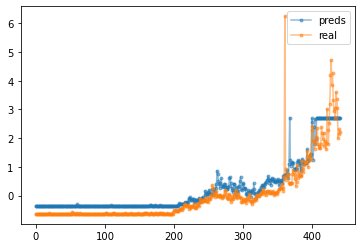

In [27]:
plt.figure()
plt.plot(train_preds, '.-', label='preds', alpha=0.5)
plt.plot(train_labels, '.-', label='real', alpha=0.5)
plt.legend()
plt.show()

100%|██████████| 106/106 [00:00<00:00, 1708.71it/s]


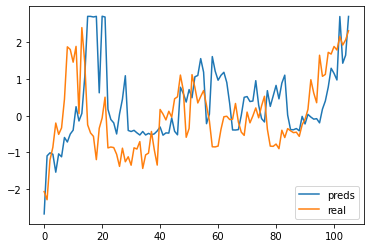

In [21]:
test_preds = []
for x in tqdm(test_tensor):
    x = x.unsqueeze(dim=-1).unsqueeze(dim=0).cuda()
    preds = model(x)
    test_preds.append(preds.item())
    


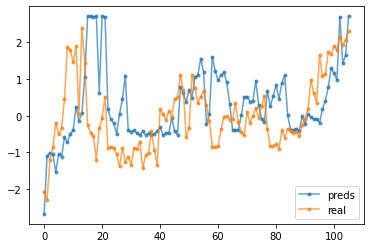

In [25]:
plt.figure()
plt.plot(test_preds, '.-', label='preds', alpha=0.7)
plt.plot(test_labels, '.-', label='real', alpha=0.7)
plt.legend()
plt.show()